In [18]:
import requests

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def extract_osm_geodata(query):
    """
    Extracts geodata from OpenStreetMap using the Overpass API.
    Parameters:
    query (str): The Overpass API query string to execute.
    Returns:
    dict: GeoJSON data retrieved by the query.
    """
    # Define the Overpass API URL
    overpass_url = "https://lz4.overpass-api.de/api/interpreter"

    # Define the parameters for the GET request
    params = {"data": query}

    # Send a GET request to the Overpass API with the query
    response = requests.get(overpass_url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()


In [7]:
def extract_route_elements(osm_data):
    """
    Extracts route elements from the OpenStreetMap data response.
    Parameters:
    osm_data (dict): The JSON response data from the Overpass API.
    Returns:
    list: A list of route elements containing 'tags' with 'route' information.
    """
    route_elements = [element for element in osm_data["elements"] if "tags" in element and "route" in element["tags"]]
    return route_elements


In [9]:
def extract_node_elements(osm_data):
    """
    Extracts node elements from the OpenStreetMap data response.
    Parameters:
    osm_data (dict): The JSON response data from the Overpass API.
    Returns:
    dict: A dictionary where the keys are node IDs and the values are the corresponding node elements.
    """
    node_elements = {element['id']: element for element in osm_data['elements'] if element['type'] == 'node'}
    return node_elements

In [11]:
def extract_route_elements(osm_data):
    """
    Extracts route elements from the OpenStreetMap data response.
    Parameters:
    osm_data (dict): The JSON response data from the Overpass API.
    Returns:
    list: A list of route elements containing 'tags' with 'route' information.
    """
    route_elements = [element for element in osm_data['elements'] if 'tags' in element and 'route' in element['tags']]
    return route_elements

In [13]:
def create_route_graph(route_elements, node_elements):
    """
    Creates a graph of routes with stop nodes and edges between consecutive stops.
    Parameters:
    route_elements (list): A list of route elements containing 'members' and 'tags'.
    node_elements (dict): A dictionary of node elements with their IDs as keys.
    Returns:
    nx.Graph: A NetworkX graph object representing the routes and stop nodes.
    """
    # Create a graph object
    G = nx.Graph()

    for route in route_elements:
        stop_nodes = [member for member in route['members'] if 'stop' in member['role']]

        # Add nodes to the graph
        for node in stop_nodes:
            ref = node['ref']
            if ref in node_elements:
                node_data = node_elements[ref]
                name = node_data['tags'].get('name', str(ref))
                colour = route['tags'].get('colour', '#808080')  # Default gray color if no color is defined

                G.add_node(ref, pos=(node_data['lon'], node_data['lat']), name=name, colour=colour)

        # Add edges between consecutive stop nodes
        for i in range(len(stop_nodes) - 1):
            G.add_edge(stop_nodes[i]['ref'], stop_nodes[i + 1]['ref'])

    return G

In [14]:

def visualize_graph(G, title):
    """
    Visualizes the graph with nodes and edges.
    Parameters:
    G (nx.Graph): A NetworkX graph object representing the routes and stop nodes.
    Returns:
    None: Displays a plot of the graph.
    """
    # Set the plot size
    plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

    # Draw the graph with nodes and edges
    pos = nx.get_node_attributes(G, 'pos')
    node_labels = nx.get_node_attributes(G, 'name')
    node_colours = list(nx.get_node_attributes(G, 'colour').values())
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=100, node_color=node_colours, font_size=8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.show()

### Extract data

In [5]:
# Query to extract subway stations in Hamburg
query = """
[out:json];
area[name="Hamburg"]->.searchArea;
relation["route"~"subway"](area.searchArea);
out meta;
>;
out body;
"""
subway_hamburg_data = extract_osm_geodata(query)

In [6]:
subway_hamburg_data

{'version': 0.6,
 'generator': 'Overpass API 0.7.62.1 084b4234',
 'osm3s': {'timestamp_osm_base': '2024-09-08T13:13:32Z',
  'timestamp_areas_base': '2024-09-08T07:42:45Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'relation',
   'id': 60691,
   'timestamp': '2024-05-06T22:45:58Z',
   'version': 244,
   'changeset': 150985418,
   'user': 'olifantoliver',
   'uid': 16780103,
   'members': [{'type': 'node', 'ref': 8117305625, 'role': 'stop'},
    {'type': 'way', 'ref': 1212391204, 'role': 'platform'},
    {'type': 'node', 'ref': 244004764, 'role': 'stop'},
    {'type': 'way', 'ref': 296769797, 'role': 'platform'},
    {'type': 'node', 'ref': 156779345, 'role': 'stop'},
    {'type': 'way', 'ref': 131405219, 'role': 'platform'},
    {'type': 'node', 'ref': 247743974, 'role': 'stop'},
    {'type': 'way', 'ref': 387157320, 'role': 'platform'},
    {'type': 'node', 'ref': 247743978, 'role':

### Extracting Route and Stop Locations from the API Response

In [8]:
# Call the function to extract route elements from the OpenStreetMap data for Hamburg's subway
route_elements =  extract_route_elements(subway_hamburg_data)

# Visualize the route of the list
route_elements[0]

{'type': 'relation',
 'id': 60691,
 'timestamp': '2024-05-06T22:45:58Z',
 'version': 244,
 'changeset': 150985418,
 'user': 'olifantoliver',
 'uid': 16780103,
 'members': [{'type': 'node', 'ref': 8117305625, 'role': 'stop'},
  {'type': 'way', 'ref': 1212391204, 'role': 'platform'},
  {'type': 'node', 'ref': 244004764, 'role': 'stop'},
  {'type': 'way', 'ref': 296769797, 'role': 'platform'},
  {'type': 'node', 'ref': 156779345, 'role': 'stop'},
  {'type': 'way', 'ref': 131405219, 'role': 'platform'},
  {'type': 'node', 'ref': 247743974, 'role': 'stop'},
  {'type': 'way', 'ref': 387157320, 'role': 'platform'},
  {'type': 'node', 'ref': 247743978, 'role': 'stop'},
  {'type': 'way', 'ref': 389549361, 'role': 'platform'},
  {'type': 'node', 'ref': 247743598, 'role': 'stop_exit_only'},
  {'type': 'way', 'ref': 298179732, 'role': 'platform_exit_only'},
  {'type': 'way', 'ref': 1280391831, 'role': ''},
  {'type': 'way', 'ref': 871573424, 'role': ''},
  {'type': 'way', 'ref': 1280391830, 'role'

In [10]:
# Call the function to extract node elements from the OpenStreetMap data for Hamburg's subway
node_elements = extract_node_elements(subway_hamburg_data)

# Visualize the node_elements list
node_elements

{15586106: {'type': 'node',
  'id': 15586106,
  'lat': 53.6190173,
  'lon': 10.0307013},
 15738749: {'type': 'node',
  'id': 15738749,
  'lat': 53.61042,
  'lon': 10.0254784},
 15739285: {'type': 'node',
  'id': 15739285,
  'lat': 53.611976,
  'lon': 10.0275924,
  'tags': {'cutting': 'yes'}},
 16381489: {'type': 'node',
  'id': 16381489,
  'lat': 53.6127576,
  'lon': 10.0280889,
  'tags': {'cutting': 'yes'}},
 16381768: {'type': 'node',
  'id': 16381768,
  'lat': 53.6064926,
  'lon': 10.0120795},
 16381803: {'type': 'node',
  'id': 16381803,
  'lat': 53.6090548,
  'lon': 10.0210988},
 16381817: {'type': 'node',
  'id': 16381817,
  'lat': 53.6094952,
  'lon': 10.0226751,
  'tags': {'embankment': 'yes',
   'railway': 'milestone',
   'railway:position': '9.7',
   'source': 'survey'}},
 16382189: {'type': 'node',
  'id': 16382189,
  'lat': 53.6051525,
  'lon': 10.0068962},
 16382190: {'type': 'node',
  'id': 16382190,
  'lat': 53.6113984,
  'lon': 10.0270286,
  'tags': {'cutting': 'yes'}},

### Constructing a Network Graph of Subway Routes

In [12]:
# Call the function to extract route elements from the OpenStreetMap data for Hamburg's subway
route_elements =  extract_route_elements(subway_hamburg_data)

# Visualize the route of the list
route_elements[0]

{'type': 'relation',
 'id': 60691,
 'timestamp': '2024-05-06T22:45:58Z',
 'version': 244,
 'changeset': 150985418,
 'user': 'olifantoliver',
 'uid': 16780103,
 'members': [{'type': 'node', 'ref': 8117305625, 'role': 'stop'},
  {'type': 'way', 'ref': 1212391204, 'role': 'platform'},
  {'type': 'node', 'ref': 244004764, 'role': 'stop'},
  {'type': 'way', 'ref': 296769797, 'role': 'platform'},
  {'type': 'node', 'ref': 156779345, 'role': 'stop'},
  {'type': 'way', 'ref': 131405219, 'role': 'platform'},
  {'type': 'node', 'ref': 247743974, 'role': 'stop'},
  {'type': 'way', 'ref': 387157320, 'role': 'platform'},
  {'type': 'node', 'ref': 247743978, 'role': 'stop'},
  {'type': 'way', 'ref': 389549361, 'role': 'platform'},
  {'type': 'node', 'ref': 247743598, 'role': 'stop_exit_only'},
  {'type': 'way', 'ref': 298179732, 'role': 'platform_exit_only'},
  {'type': 'way', 'ref': 1280391831, 'role': ''},
  {'type': 'way', 'ref': 871573424, 'role': ''},
  {'type': 'way', 'ref': 1280391830, 'role'

### Visualize the graph

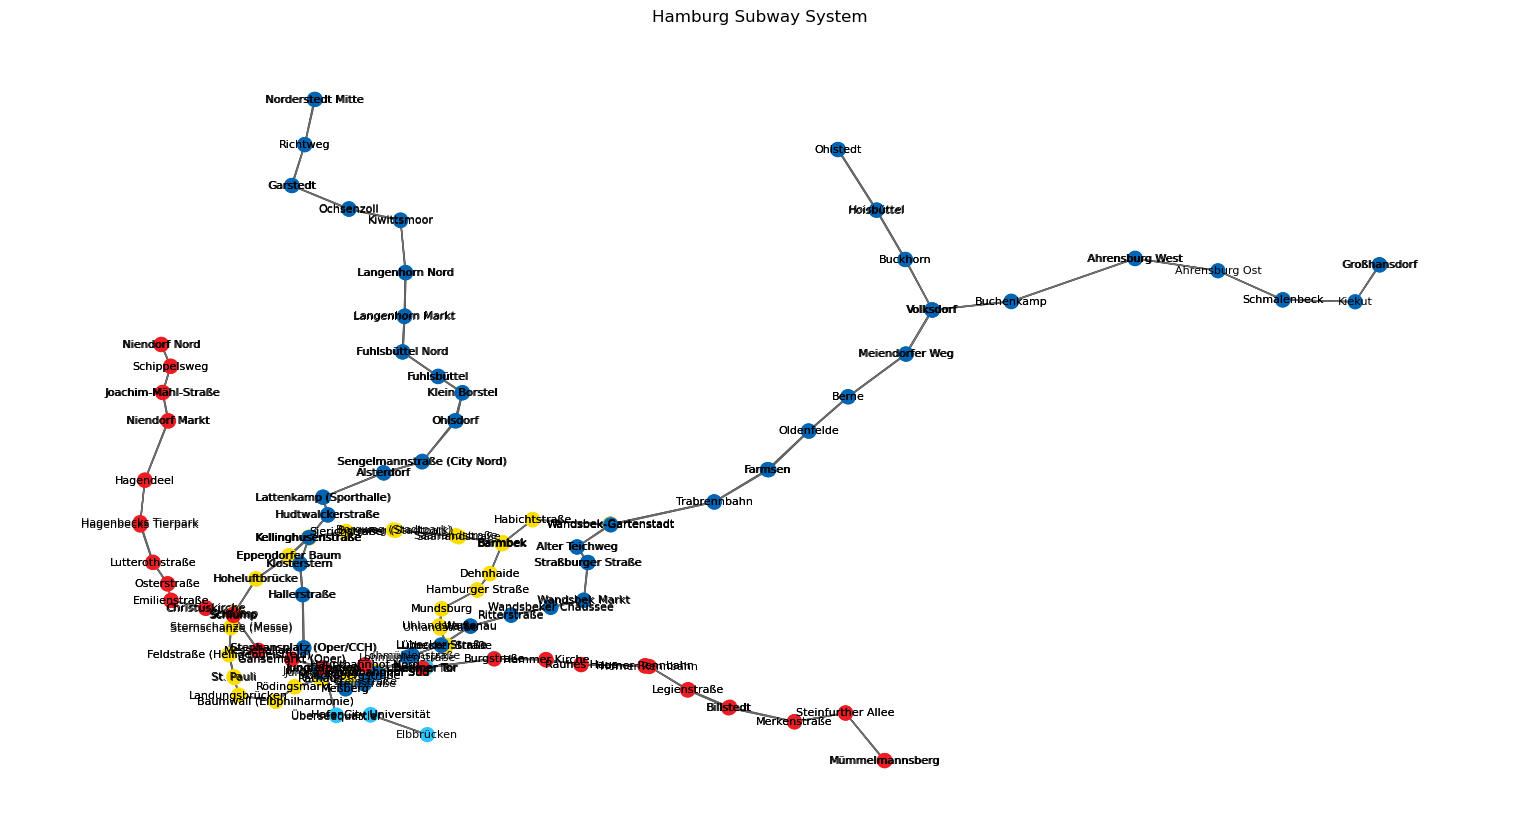

In [19]:
# Create the graph for the Hamburg subway system
subway_hamburg_G = create_route_graph(route_elements, node_elements)

# Visualize the graph with a title
visualize_graph(subway_hamburg_G, 'Hamburg Subway System')

### Creation of an Interactive Graph Visualization Using Folium

In [ ]:
area_search = "Madrid"
route_type = "subway"

# Query to extract subway stations in Hamburg
query = fr"""
[out:json];
area[name={area_search}]->.searchArea;
relation["route"~"{route_type}"](area.searchArea);
out meta;
>;
out body;
"""

# Extract subway data using the Overpass API
subway_data = extract_osm_geodata(query)

# Call the function to extract route elements from the OpenStreetMap data
route_elements =  extract_route_elements(subway_data)

# Call the function to extract node elements from the OpenStreetMap data
node_elements = extract_node_elements(subway_data)

# Create a graph of the subway network
G = create_route_graph(route_elements, node_elements)

# Visualize the Networkx Graph with Folium
map = create_folium_map(G, zoom_start=12)
map